In [ ]:
# Imports PIL module
import urllib.request
from PIL import Image
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Logbook_Dataset')

In [ ]:
# install dataset library, sentencepiece and tensor board packages
!pip install -q datasets sentencepiece tensorboard

In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
# Check the current working directory
curr_path = os.getcwd()
print(curr_path)


# Load dataset
dataset = load_dataset("imagefolder", data_dir=curr_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

In [ ]:
#install Transformers package
!pip install transformers==4.45.2 sentence-transformers==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 132.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Random sample is 8
OCR text is {"Work Order No": "JC42287634", "Aircraft Registration No": "N5391J", "Aircraft Type": "Cessna 206", "Aircraft Serial No": "FG1418", "Aircraft Total Hours": "3400", "Aircraft Total Cycles": "2400", "Engine Serial No": "LM191434", "Engine Total Hours": "1800", "Date": "01/08/2034", "Repair Station No": "CA1312"}


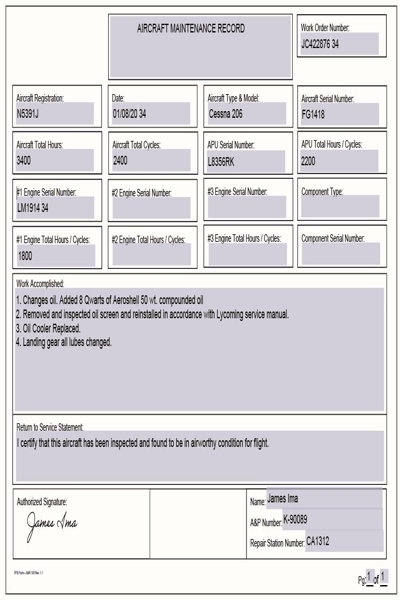

In [4]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((400,600))

In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer
#This function will convert the json annotations into tokens
def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[5]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

In [7]:
print(f"Sample: {proc_dataset[5]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

Sample: <s><s_Work Order No>JC42201212</s_Work Order No><s_Repair Station No>CA1312</s_Repair Station No><s_Engine Total Hours>2000</s_Engine Total Hours><s_Engine Serial No>HG567RE</s_Engine Serial No><s_Date>05/11/2012</s_Date><s_Aircraft Type>Cessna 206</s_Aircraft Type><s_Aircraft Total Hours>3200</s_Aircraft Total Hours><s_Aircraft Total Cycles>2300</s_Aircraft Total Cycles><s_Aircraft Serial No>KG6418</s_Aircraft Serial No><s_Aircraft Registration No>FY388M</s_Aircraft Registration No></s>
New special tokens: ['<s_TBO>', '</s_TBO>', '<s_Model No>', '</s_Model No>', '<s_Hub Serial No>', '</s_Hub Serial No>', '<s_Engine Manufacturer>', '</s_Engine Manufacturer>', '<s_Date>', '</s_Date>', '<s_Blade Design No>', '</s_Blade Design No>', '<s_Aircraft Registration No>', '</s_Aircraft Registration No>', '<s_Work Order No>', '</s_Work Order No>', '<s_Repair Station No>', '</s_Repair Station No>', '<s_Engine Total Hours>', '</s_Engine Total Hours>', '<s_Engine Serial No>', '</s_Engine Seri

In [ ]:
from transformers import DonutProcessor

# Load Donut processor of the pre-trained model
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

In [ ]:
#this function will convert the images into tensors
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

In [ ]:
#print few sample tokens
print(f"Sample1: {processed_dataset[8]}")
print(f"New special tokens1: {new_special_tokens + [task_start_token] + [eos_token]}")
print(f"Sample2: {processed_dataset[5]}")
print(f"New special tokens2: {new_special_tokens + [task_start_token] + [eos_token]}")

In [ ]:
## COMMENT IN in case you want to save the processed dataset to disk in case of error later
#This will save the processor into your Google drive
processed_dataset.save_to_disk("processed_dataset")
processor.save_pretrained("processor")

In [ ]:
#split the train and test data into 85 and 15 %
processed_dataset = processed_dataset.train_test_split(test_size=0.15)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 127
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 23
    })
})


In [ ]:
#!pip install -q git+https://github.com/huggingface/transformers.git

import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load pre-traned model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
#model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
from huggingface_hub import notebook_login
#Hugging face login details
notebook_login()

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-engine_logbook"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=20,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

# Start training the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
50,5.005000
100,0.972300
150,0.280200
200,0.164300
250,0.105700
300,0.085600
350,0.068900


Step,Training Loss
50,5.005000
100,0.972300
150,0.280200
200,0.164300
250,0.105700
300,0.085600
350,0.068900
400,0.082300
450,0.044200
500,0.022900


TrainOutput(global_step=640, training_loss=0.5399263188242912, metrics={'train_runtime': 3683.3327, 'train_samples_per_second': 0.69, 'train_steps_per_second': 0.174, 'total_flos': 4.467575021395968e+18, 'train_loss': 0.5399263188242912, 'epoch': 20.0})

In [ ]:
# Save processor to Hugging face repo and create model card 
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()